# Experiment 1. Тестирование логистической регрессии с кодированием признаков через WOE

В данном проекте мы будем тестировать логистическую регрессию, используя метод кодирования признаков через Weight of Evidence (WOE). Этот метод позволяет преобразовать категориальные признаки в числовые, что может улучшить производительность модели.

## Цель

Целью данного тестирования является определение производительности логистической регрессии с использованием WOE-кодирования и сравнение ее с моделью, использующей исходные признаки. Мы будем оценивать производительность модели с использованием метрики ROC AUC и проводить t-тест для сравнения результатов.

## Ход работы

1. **Загрузка данных**: Мы начнем с загрузки и предварительной обработки данных, чтобы подготовить их для обучения модели.

2. **Кодирование признаков**: Применим WOE-кодирование к категориальным признакам, чтобы преобразовать их в числовые значения. Это позволит логистической регрессии лучше справляться с этими признаками.

3. **Разделение данных**: Данные будут разделены на обучающую и тестовую выборки, что позволит нам оценить производительность модели на невидимых данных.

4. **Обучение модели**: Мы обучим логистическую регрессию на данных с WOE-кодированием и на исходных данных.

5. **Оценка моделей**: Каждая модель будет оценена на тестовой выборке с использованием метрики ROC AUC. Мы будем сравнивать производительность моделей, чтобы определить, какая из них показывает наилучшие результаты.

6. **Сравнение распределений**: Мы выведем значения WOE для закодированных признаков и сравним их распределения с исходными признаками, чтобы оценить влияние кодирования.

7. **Многократные итерации обучения**: Мы проведем множество итераций обучения на сбалансированных данных, чтобы оценить стабильность и надежность модели.

8. **Сравнение результатов**: Наконец, мы сравним результаты различных итераций обучения с помощью t-теста, чтобы определить, есть ли статистически значимые различия в производительности модели при использовании WOE-кодирования и без него.

## Заключение

В результате данного тестирования мы сможем определить, как WOE-кодирование влияет на производительность логистической регрессии, а также выявить, есть ли статистически значимые различия в производительности модели при использовании различных методов кодирования признаков.


### Библиотеки

In [18]:
pip install category_encoders shap

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
import shap

import pandas as pd
import category_encoders as ce
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from utils.roc_auc import plot_roc_curve
from utils.model_comparison import run_model_iterations, compare_model_statistics

In [20]:
TARGET_COLUMN = 'TARGET'

Для обучения модели будем использовать данные без предобработки тк в них признаки уже закодированные

In [21]:
data = pd.read_csv("./data/home-credit-default-risk/application_train.csv")

In [22]:
data.shape

(307511, 122)

In [23]:
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
non_categorical_cols = [col for col in data.columns if col not in categorical_cols and col != TARGET_COLUMN]

### Кодирование признаков и обучение модели

In [24]:
def encode_woe(data):
    # Создаем экземпляр WOEEncoder, указывая колонки с категориальными данными
    categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
    woe_encoder = ce.WOEEncoder(cols=categorical_cols)
    
    # Обучаем WOEEncoder на тренировочных данных
    data_encoded = woe_encoder.fit_transform(data.drop(columns=[TARGET_COLUMN]), data[TARGET_COLUMN])
    
    # Добавляем колонку с целевым значением обратно
    data_encoded[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return data_encoded

data_encoded = encode_woe(data)

In [25]:
data_encoded.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
0,100002,0.036202,0.250941,0.056221,-0.015113,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,100003,0.036202,-0.154315,0.056221,0.033532,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,100004,-0.415030,0.250941,-0.117305,-0.015113,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,100006,0.036202,-0.154315,0.056221,-0.015113,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
4,100007,0.036202,0.250941,0.056221,-0.015113,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0


Как было видно на EDA в данных много колонок содержат пропуски. Заменим их на средние (тестировались median и most_frequent, но лучше оказалось mean). Добавим этот этап в пайплайн обучения модели

/Users/pelageya/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


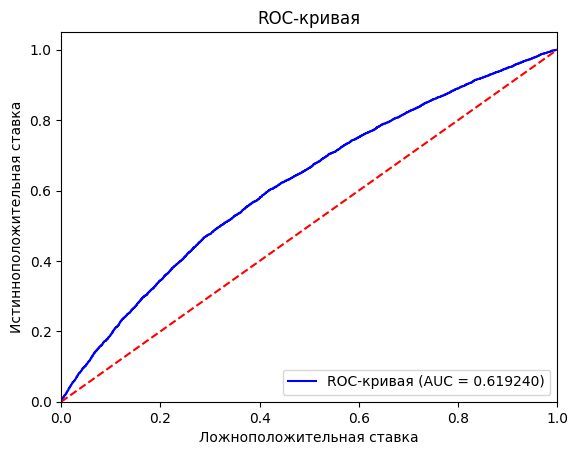

In [26]:
# Разделяем данные на признаки и целевую переменную
X = data_encoded.drop(columns=[TARGET_COLUMN])
y = data_encoded[TARGET_COLUMN]

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучаем логистическую регрессию
imputer = SimpleImputer(strategy='most_frequent') 
model = LogisticRegression()

pipeline = Pipeline(steps=[('imputer', imputer), ('model', model)])
pipeline.fit(X_train, y_train)

roc_auc = plot_roc_curve(pipeline, X_test, y_test, need_plot=0)

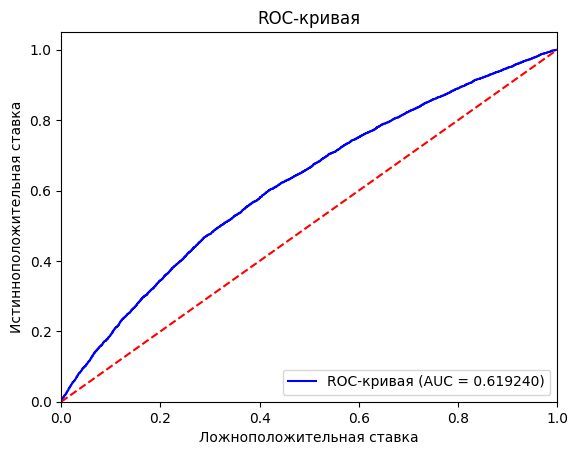

In [27]:
roc_auc = plot_roc_curve(pipeline, X_test, y_test, need_plot=1)

In [28]:
model1_roc_auc = roc_auc

Качество повысилось по сравнению с бейзлайном

In [29]:
%store -r model0_roc_auc

In [30]:
f"ROC AUC повысилась по сравнению с бейзлайном на {model1_roc_auc - model0_roc_auc}"

'ROC AUC повысилась по сравнению с бейзлайном на -0.01423972837830767'

Выведем график важности признаков по методу SHAP

In [31]:
X_test.isnull().sum()

SK_ID_CURR                       0
NAME_CONTRACT_TYPE               0
CODE_GENDER                      0
FLAG_OWN_CAR                     0
FLAG_OWN_REALTY                  0
                              ... 
AMT_REQ_CREDIT_BUREAU_DAY     8308
AMT_REQ_CREDIT_BUREAU_WEEK    8308
AMT_REQ_CREDIT_BUREAU_MON     8308
AMT_REQ_CREDIT_BUREAU_QRT     8308
AMT_REQ_CREDIT_BUREAU_YEAR    8308
Length: 121, dtype: int64

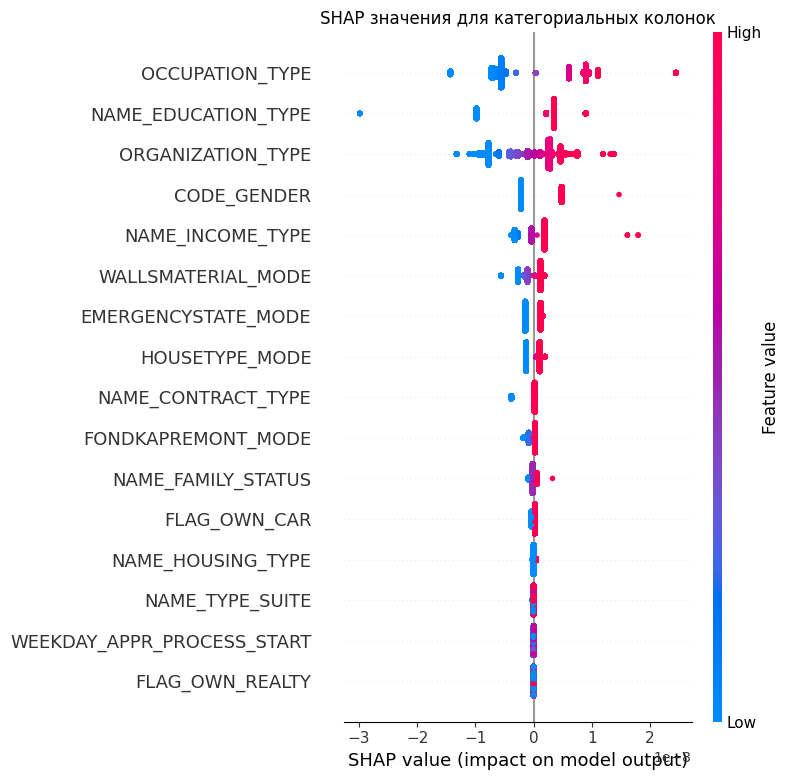

In [40]:
# Оценка значимости признаков с помощью SHAP
explainer = shap.Explainer(pipeline.named_steps['model'], X_train)
shap_values = explainer(X_test)

# категориальные колонки
X_test_categorical = X_test[categorical_cols]
categorical_indices = [X.columns.get_loc(col) for col in categorical_cols]
shap_values_categorical = shap_values[:, categorical_indices]

# некатегориальные колонки
X_test_non_categorical = X_test[non_categorical_cols]
non_categorical_indices = [X.columns.get_loc(col) for col in non_categorical_cols]
shap_values_non_categorical = shap_values[:, non_categorical_indices]

# Визуализация значимости признаков для категориальных колонок
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
shap.summary_plot(shap_values_categorical, X_test_categorical, show=False)
plt.title('SHAP значения для категориальных колонок')

plt.tight_layout()
plt.show()

Посмотрим распределение шап значений у категориальных и некатегориальных колонок, чтобы сравнить насколько важны для модели оказались закодмированные через WOE колонки 

In [34]:
# Извлекаем значения SHAP
shap_values_categorical_array = shap_values_categorical.values
shap_values_non_categorical_array = shap_values_non_categorical.values

shap_df_categorical = pd.DataFrame(shap_values_categorical_array, columns=categorical_cols)
shap_df_categorical['type'] = 'Categorical'

# Создаем DataFrame для SHAP значений некатегориальных признаков
shap_df_non_categorical = pd.DataFrame(shap_values_non_categorical_array, columns=non_categorical_cols)
shap_df_non_categorical['type'] = 'Non-Categorical'

# Плоский DataFrame для визуализации
shap_df_categorical_melted = shap_df_categorical.melt(value_vars=categorical_cols, var_name='feature', value_name='shap_value')
shap_df_non_categorical_melted = shap_df_non_categorical.melt(value_vars=non_categorical_cols, var_name='feature', value_name='shap_value')

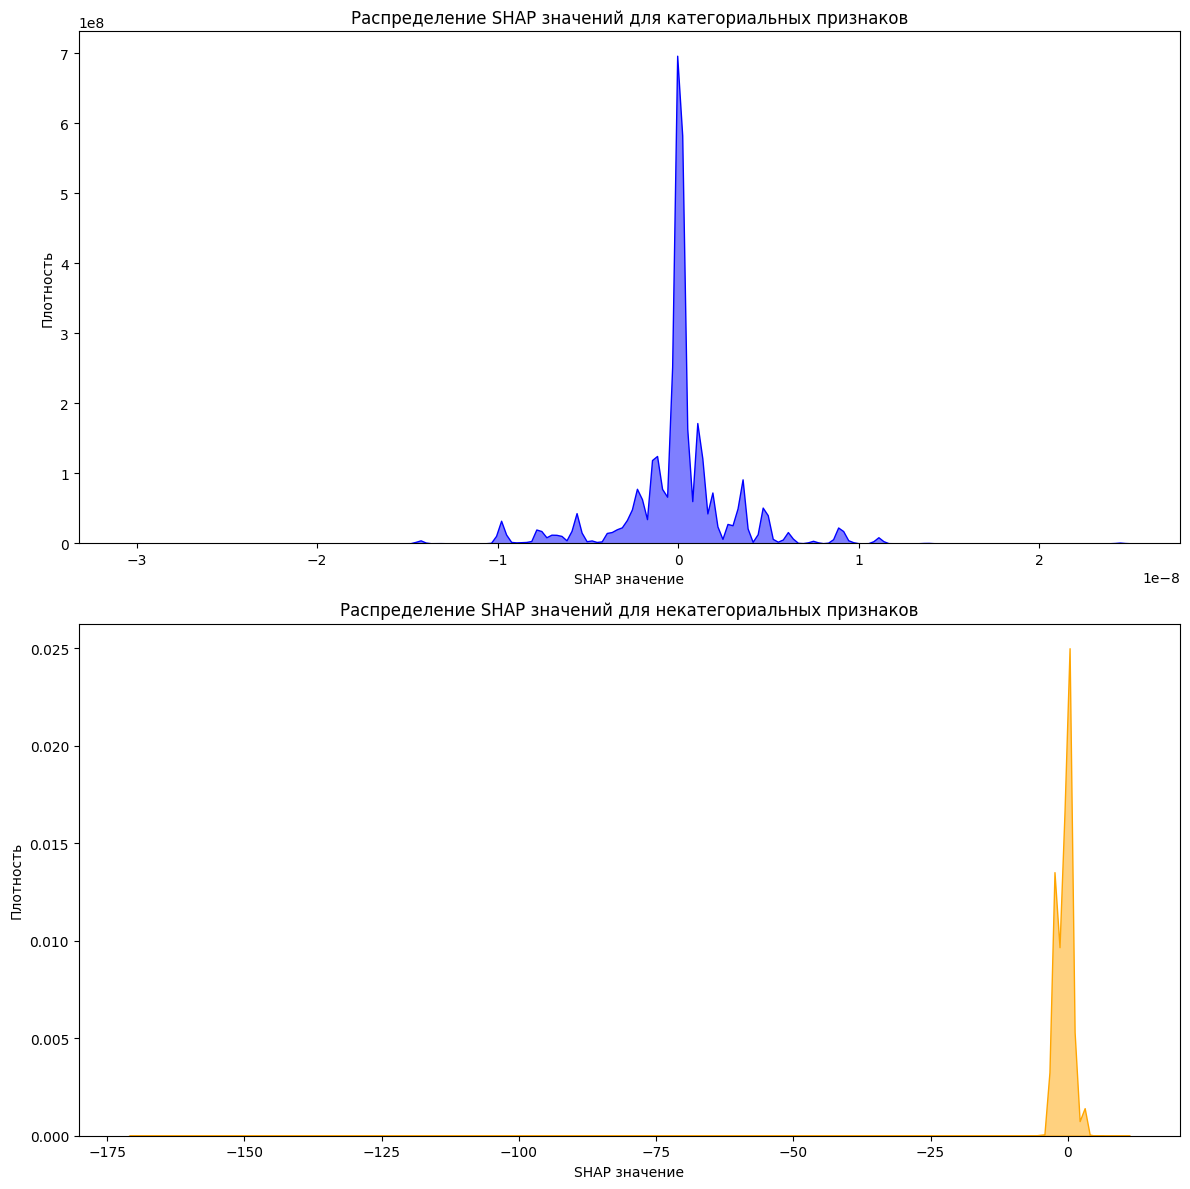

In [35]:
# Создаем фигуру с двумя подграфиками
plt.figure(figsize=(12, 12))

# График для категориальных признаков
plt.subplot(2, 1, 1) 
sns.kdeplot(data=shap_df_categorical_melted, x='shap_value', fill=True, color='blue', alpha=0.5)
plt.title('Распределение SHAP значений для категориальных признаков')
plt.xlabel('SHAP значение')
plt.ylabel('Плотность')

# График для некатегориальных признаков
plt.subplot(2, 1, 2) 
sns.kdeplot(data=shap_df_non_categorical_melted, x='shap_value', fill=True, color='orange', alpha=0.5)
plt.title('Распределение SHAP значений для некатегориальных признаков')
plt.xlabel('SHAP значение')
plt.ylabel('Плотность')

# Отображаем графики
plt.tight_layout()
plt.show()

На графиках видно, что распределение SHAP значений для категориальных признаков значительно отличается от распределения для некатегориальных признаков. Несмотря на то, что у обоих распределений математическое ожидание близко к нулю, важным показателем является дисперсия распределения.

Для категориальных признаков дисперсия значительно ниже, что указывает на то, что лишь немногие из этих признаков оказали заметное влияние на модель. Это может свидетельствовать о том, что кодирование категориальных признаков с использованием метода WOE не предоставило модели значимой информации. Возможно, это связано с тем, что сами по себе эти признаки не содержат полезной информации для предсказания.



In [36]:
model1_roc_auc_distr = run_model_iterations(pipeline, X_train, y_train, X_test, y_test, n_iterations=100)

Training iterations:   0%|          | 0/100 [00:00<?, ?it/s]/Users/pelageya/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Training iterations:   1%|          | 1/100 [00:05<08:16,  5.02s/it]/Users/pelageya/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


In [37]:
%store model1_roc_auc_distr

Stored 'model1_roc_auc_distr' (ndarray)


In [38]:
%store -r model0_roc_auc_distr

In [39]:
compare_model_statistics(model0_roc_auc_distr, model1_roc_auc_distr)

Среднее ROC AUC Model 1: 0.633217777371199
Среднее ROC AUC Model 2: 0.6192395699922496
Модель 1 имеет большую метрику ROC AUC на 0.013978207378949392.
t-статистика: 1252733948660584.8
p-значение: 0.0
Существует статистически значимая разница между моделями.


/Users/pelageya/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Кодирование через WOE ухудшило результаты